In [6]:
import os, glob
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import torch.nn as nn
import pathlib
import sys
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
import architectures as arch
from architectures.callbacks import LightningWrapper
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH
from functools import partial
import stir.model.tools.helpers as helpers
import stir
import itertools

In [26]:
EVAL_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']

CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': \
            '/NS/robustness_3/work/vnanda/adv-robustness/logs/robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
        },
    'resnet50_mrl': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints'\
                  '/imagenet1k/r50_mrl1_e0_ff2048.pt'
    },
    'resnet50_ff8': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff8.pt'
    },
    'resnet50_ff16': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff16.pt'
    },
    'resnet50_ff32': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff32.pt'
    },
    'resnet50_ff64': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff64.pt'
    },
    'resnet50_ff128': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff128.pt'
    },
    'resnet50_ff256': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff256.pt'
    },
    'resnet50_ff512': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff512.pt'
    },
    'resnet50_ff1024': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff1024.pt'
    },
    'vit_small_patch16_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
    'vit_small_patch32_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
}

MODEL_TO_TOTAL = {
    'resnet50': 2048,
    'resnet50_mrl': 2048
}

SEED = 2
BATCH_SIZE = 100

In [27]:
class MaskedModel(nn.Module):
    def __init__(self, model, mask):
        super().__init__()
        self.mask = mask
        self.model = model
    
    def forward(self, x, *args, **kwargs):
        out, latent = self.model(x, *args, **kwargs)
        return out, latent[:,self.mask]

In [28]:
def find_chosen_neurons(m1, mode, seeds, numbers):
    frac_to_chosen_neurons = {}
    name, param = list(m1.model.named_modules())[-1]
    in_fts = param.in_features
    if mode == 'random':
        for partial_seed in seeds:
            for num_neurons in numbers:
                linear = nn.Linear(num_neurons, dsmd.DATASET_PARAMS[SOURCE_DATASET]['num_classes'])
                torch.manual_seed(partial_seed)
                chosen_neurons = torch.randperm(in_fts)[:num_neurons]
                if num_neurons in frac_to_chosen_neurons:
                    frac_to_chosen_neurons[num_neurons].append(chosen_neurons)
                else:
                    frac_to_chosen_neurons[num_neurons] = [chosen_neurons]
    elif mode == 'first':
        for num_neurons in numbers:
            chosen_neurons = torch.arange(in_fts)[:num_neurons]
            if num_neurons in frac_to_chosen_neurons:
                frac_to_chosen_neurons[num_neurons].append(chosen_neurons)
            else:
                frac_to_chosen_neurons[num_neurons] = [chosen_neurons]
    return frac_to_chosen_neurons

In [29]:
def results(SOURCE_DATASET, MODEL, APPENDS, PARTIAL_CHOICE_SEEDS, NUMBERS, MODE):
    results = []
    for eval_ds in EVAL_DATASETS:
        print (eval_ds)
        append_to_frac_ckas = {}
        dm = DATA_MODULES[eval_ds](
            data_dir=DATA_PATH_IMAGENET if 'imagenet' in eval_ds else DATA_PATH,
            transform_train=dsmd.TEST_TRANSFORMS_DEFAULT(224),
            transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
            batch_size=BATCH_SIZE)
        dm.init_remaining_attrs(eval_ds)
        for append in APPENDS:
            m1 = arch.create_model(MODEL, SOURCE_DATASET, pretrained=True,
                                   checkpoint_path=CHECKPOINT_PATHS[MODEL][append], seed=SEED, 
                                   callback=partial(LightningWrapper, 
                                                    dataset_name=SOURCE_DATASET,
                                                    inference_kwargs={'with_latent': True}),
                                  loading_function_kwargs={'strict': False} \
                                   if 'resnet50_mrl' in MODEL or 'resnet50_ff' in MODEL else {})
            frac_to_chosen_neurons = find_chosen_neurons(m1, MODE, PARTIAL_CHOICE_SEEDS, NUMBERS)
            frac_to_ckas = {}
            for num_neurons in NUMBERS[:-1]: # last one is full layer
                full_mask = frac_to_chosen_neurons[NUMBERS[-1]]
                for mask1, mask2 in itertools.product(frac_to_chosen_neurons[num_neurons], full_mask):
                    stir_score = stir.STIR(MaskedModel(m1, mask1), MaskedModel(m1, mask2), 
                        helpers.InputNormalize(dsmd.STANDARD_MEAN, dsmd.STANDARD_STD), 
                        helpers.InputNormalize(dsmd.STANDARD_MEAN, dsmd.STANDARD_STD),
                        (dm.test_dataloader(), 1000), verbose=False, layer1_num=None, 
                        layer2_num=None, no_opt=True, cka_only=True)
                    if num_neurons in frac_to_ckas:
                        frac_to_ckas[num_neurons].append(stir_score.rsm)
                    else:
                        frac_to_ckas[num_neurons] = [stir_score.rsm]

            append_to_frac_ckas[append] = frac_to_ckas
        results.append(append_to_frac_ckas)
    
    plt_str = '== CKA Analysis between part and whole layer ==\n\n'
    for idx, eval_ds in enumerate(EVAL_DATASETS):
        plt_str += f'=== {eval_ds} ===\n\n'
        for append in APPENDS:
            frac_to_ckas = results[idx][append]
            x_vals, y_vals = list(zip(*sorted(frac_to_ckas.items(), key=lambda t: t[0])))
            plt_str += '== {} ==\n\n{}\n\n'.format(
                append,
                plt_hp.get_wiki_link(plt_hp.line_plot(
                    [[np.mean(_y) for _y in y_vals]], 'Number of Neurons', 
                    'CKA between fraction and full', f'Eval On {eval_ds}, mode = {MODE}', 
                    subfolder=SOURCE_DATASET, filename=f'part-whole-{MODEL}-{append}-{eval_ds}-{MODE}', 
                    extension='png', x_vals=x_vals, 
                    legend_vals=['CKA (fraction, full)'], vertical_line=None, 
                    colors=None, linestyles=['-', '--'],
                    y_lims=(0.,1.1), root_dir='.', paper_friendly_plots=False, 
                    plot_inside=False, legend_location='best', savefig=True, figsize=(10,6), 
                    marker=[True], results_subfolder_name='cka_analysis_part_whole', 
                    grid_spacing=None, y_err=[[np.std(_y) for _y in y_vals]], legend_ncol=None), 
                                     SERVER_PROJECT_PATH, size=700))
    
    with open(f'./results/cka_analysis_part_whole/{SOURCE_DATASET}/'
              f'wiki_results-{MODEL}-{MODE}.txt', 'w') as fp:
        fp.write(plt_str)

    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 
                                          'cka_analysis_part_whole', SOURCE_DATASET)], 
            'results', SERVER_PROJECT_PATH, '.png')
    return results

Global seed set to 2


cifar10


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass


Global seed set to 2


Not doing a second pass
cifar100


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass


Global seed set to 2


Not doing a second pass
flowers


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass


Global seed set to 2


Not doing a second pass
oxford-iiit-pets


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
[(8, 16, 32, 64, 128, 256, 512, 1024)] [[0.6074320077896118, 0.7256301045417786, 0.8636041879653931, 0.9507784843444824, 0.9864566326141357, 0.9958949685096741, 0.9986384510993958, 0.9996110796928406]]


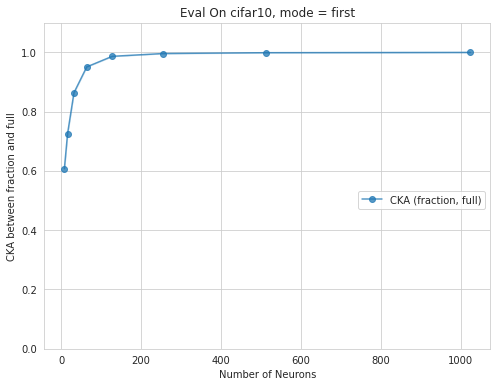

[(8, 16, 32, 64, 128, 256, 512, 1024)] [[0.589847207069397, 0.7024728059768677, 0.8687729835510254, 0.9596224427223206, 0.989015519618988, 0.9965640902519226, 0.9987717270851135, 0.9996177554130554]]


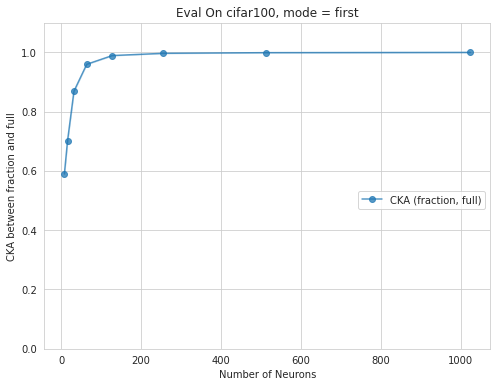

[(8, 16, 32, 64, 128, 256, 512, 1024)] [[0.5061789751052856, 0.6457599997520447, 0.8475372791290283, 0.9603521823883057, 0.9898011088371277, 0.9963070154190063, 0.9987597465515137, 0.9996131658554077]]


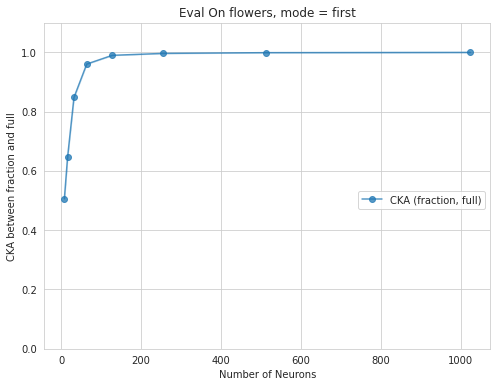

[(8, 16, 32, 64, 128, 256, 512, 1024)] [[0.551950216293335, 0.6372407674789429, 0.8114598989486694, 0.9368049502372742, 0.9833474159240723, 0.9955934286117554, 0.9986931085586548, 0.9996815919876099]]


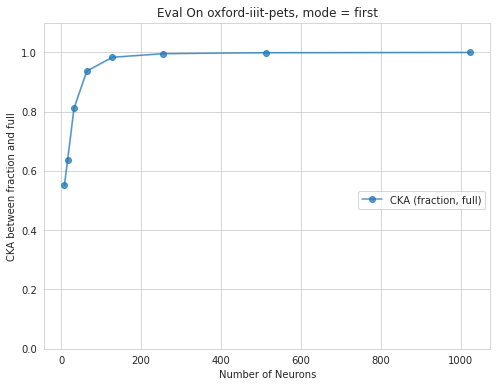

Uploading results in ['results/cka_analysis_part_whole/imagenet'] to contact.mpi-sws.org...
Uploading 20 files to server
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-imagenet-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-imagenet-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-cifar100-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-cifar100-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-flowers-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-flowers-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-cifar10-random.png to /home/vnanda/public_html/results/partially_inverted

Global seed set to 2


copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-cifar10-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-cifar10-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-imagenet-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-imagenet-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-cifar100-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-cifar100-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50-robustl2eps3-imagenet-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50-robustl2eps3-imagenet-random.png
copying results/cka_analysis_part_whol

No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

In [ ]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50_mrl'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())
NUMBERS = [8,16,32,64,128,256,512,1024,2048]
SEEDS = list(range(1,6))

resnet50_mrl_first = results(SOURCE_DATASET, MODEL, APPENDS, [], NUMBERS, 'first')
resnet50_mrl_random = results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')

In [ ]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())
NUMBERS = [8,16,32,64,128,256,512,1024,2048]
FRACTIONS = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9, 1.]
SEEDS = list(range(1,6))

resnet50_numbers = results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')
resnet50_fracs = results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, 
                         [int(x * NUMBERS[-1]) for x in FRACTIONS], 'random')

Global seed set to 2


cifar10


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
cifar100


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
flowers


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
oxford-iiit-pets


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

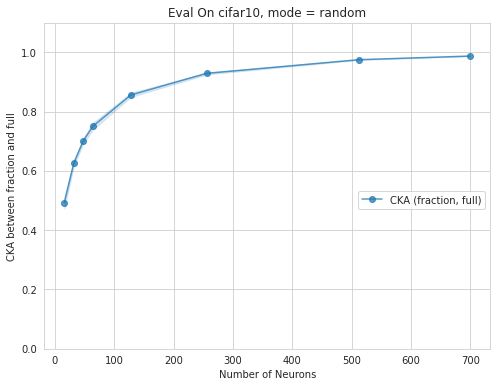

[(16, 32, 48, 64, 128, 256, 512, 700)] [[0.4717876183986664, 0.6249566555023194, 0.7109176683425903, 0.7606812858581543, 0.8564564061164855, 0.9310324382781983, 0.9733140063285828, 0.9868577575683594]]


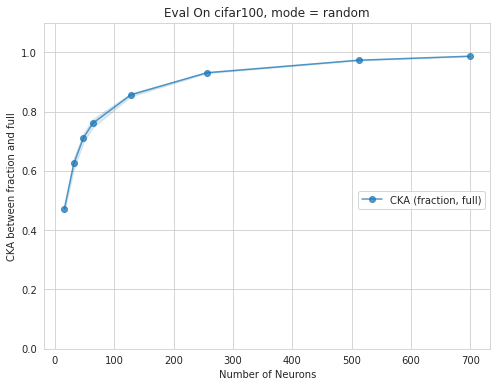

[(16, 32, 48, 64, 128, 256, 512, 700)] [[0.5320304298400879, 0.652528862953186, 0.720739324092865, 0.7724098968505859, 0.873745059967041, 0.9417645907402039, 0.9791545510292053, 0.9899269270896912]]


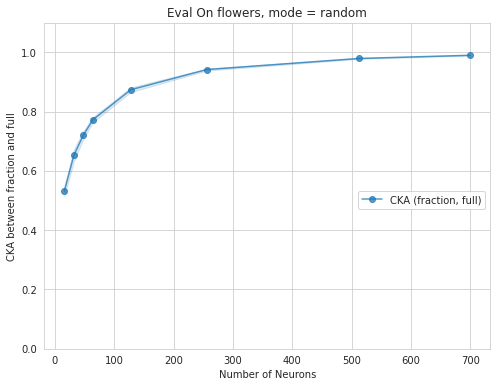

[(16, 32, 48, 64, 128, 256, 512, 700)] [[0.47775604367256164, 0.6165078711509705, 0.6935504865646362, 0.7478532814979553, 0.8527411842346191, 0.929678647518158, 0.974926414489746, 0.9882236003875733]]


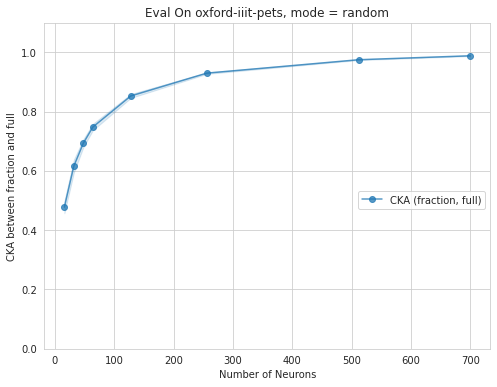

Uploading results in ['results/cka_analysis_part_whole/imagenet'] to contact.mpi-sws.org...
Uploading 24 files to server
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-imagenet-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-imagenet-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-cifar100-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-cifar100-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-flowers-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-flowers-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-cifar10-random.png to /home/vnanda/public_html/results/partially_inverted

Global seed set to 2


copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-flowers-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-flowers-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-cifar10-first.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_mrl-nonrob-cifar10-first.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-oxford-iiit-pets-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50-nonrob-oxford-iiit-pets-random.png
copying results/cka_analysis_part_whole/imagenet/part-whole-resnet50_ff1024-nonrob-cifar100-random.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis_part_whole/imagenet/part-whole-resnet50_ff1024-nonrob-cifar100-random.png
copying results/cka_anal

No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass


Exception in thread Thread-5685:
Traceback (most recent call last):
  File "/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 297, in rebuild_storage_fd
    fd = df.detach()
  File "/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/

KeyboardInterrupt: 

In [20]:
MODELS = ['resnet50_ff1024', 'resnet50_ff512', 'resnet50_ff256', 'resnet50_ff128',
          'resnet50_ff64', 'resnet50_ff32', 'resnet50_ff16', 'resnet50_ff8']
NUMBERS = [
    [16,32,48,64,128,256,512,700,1024],
    [16,32,48,64,128,256,400,512],    
    [5,20,50,100,150,200,256],
    [4,10,16,32,40,75,100,128],    
    [4,10,16,32,45,50,58,64],
    [2,6,8,10,16,24,32],
    [2,6,8,10,14,16],
    [1,2,4,6,8]
]
SEEDS = list(range(1,6))
APPENDS = ['nonrob']
SOURCE_DATASET = 'imagenet'

resnet50_width_results = []
for model, NUMS in zip(MODELS, NUMBERS):
    resnet50_width_results.append(results(SOURCE_DATASET, model, APPENDS, SEEDS, NUMS, 'random'))

../plot_helper.py:119: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  linestyle=linestyles[i] if linestyles is not None else '-',


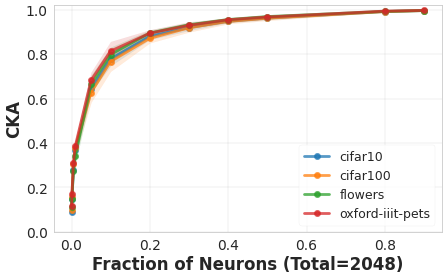

../plot_helper.py:119: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  linestyle=linestyles[i] if linestyles is not None else '-',


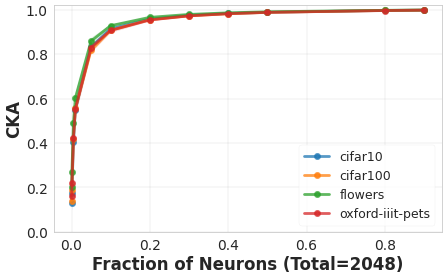

In [23]:
for append in CHECKPOINT_PATHS['resnet50'].keys():
    all_x_vals, all_y_vals, all_full_accs = [], [], []
    for idx, ft_ds in enumerate(EVAL_DATASETS[1:]):
        x, y = list(zip(*sorted(
            resnet50_fracs_test[idx+1][append].items(), key=lambda i:i[0])))
        all_x_vals.append([x_/NUMBERS[-1] for x_ in x])
        all_y_vals.append(y)
    plt_hp.line_plot(
        [[np.mean(_y) for _y in y_vals] for y_vals in all_y_vals], 
        'Fraction of Neurons (Total=2048)', 'CKA', '', 
        subfolder=SOURCE_DATASET, filename=f'part-whole-{MODEL}-{append}-allds-random_test', 
        extension='png', x_vals=all_x_vals, legend_vals=EVAL_DATASETS[1:], vertical_line=None, 
        colors=plt_hp.COLORS[:len(EVAL_DATASETS)], 
        linestyles=['-']*len(EVAL_DATASETS), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='lower right', savefig=True, figsize=(10,6), 
        marker=[True] * len(EVAL_DATASETS), 
        results_subfolder_name='cka_analysis_part_whole', grid_spacing=None, 
        y_err=[[np.std(_y) for _y in y_vals] for y_vals in all_y_vals], legend_ncol=None)

[[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]] [[0.26035134971141816, 0.33952470660209655, 0.4479468405246735, 0.5584483671188355, 0.6971416354179383, 0.8104029774665833, 0.904316759109497, 0.9633303928375244], [0.3690176689624786, 0.5015510320663452, 0.6391395878791809, 0.7593450689315796, 0.8640675711631775, 0.9315398001670837, 0.9686186265945435, 0.9889543581008912], [0.6074320077896118, 0.7256301045417786, 0.8636041879653931, 0.9507784843444824, 0.9864566326141357, 0.9958949685096741, 0.9986384510993958, 0.9996110796928406], [0.3062326407432556, 0.39226473212242124, 0.4499229884147644, 0.472963182926178, 0.6145561099052429, 0.6458614897727967, 0.7990280699729919, 0.9137866187095642]]


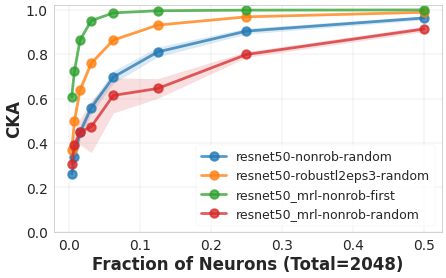

[[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]] [[0.28464108884334566, 0.34670570015907287, 0.439247282743454, 0.5374640989303588, 0.6835433673858643, 0.7997689533233643, 0.8973317766189575, 0.9619931221008301], [0.37974428296089174, 0.502960422039032, 0.6368060374259948, 0.7490229201316834, 0.8521610689163208, 0.9265574860572815, 0.9662401437759399, 0.9886884641647339], [0.589847207069397, 0.7024728059768677, 0.8687729835510254, 0.9596224427223206, 0.989015519618988, 0.9965640902519226, 0.9987717270851135, 0.9996177554130554], [0.270278268456459, 0.38576366782188415, 0.48144703269004824, 0.501016434431076, 0.6564222812652588, 0.6764755868911743, 0.8151285886764527, 0.9260945272445679]]


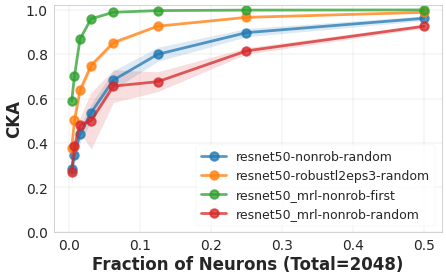

[[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]] [[0.2630270087718964, 0.3321716904640198, 0.4233644270896912, 0.5570378613471985, 0.7246480298042297, 0.8291889762878418, 0.9183903479576111, 0.9697975873947143], [0.4595302093029022, 0.5583329224586486, 0.6927973103523254, 0.7996344065666199, 0.8895251750946045, 0.9421462297439576, 0.9748458218574524, 0.9911941361427307], [0.5061789751052856, 0.6457599997520447, 0.8475372791290283, 0.9603521823883057, 0.9898011088371277, 0.9963070154190063, 0.9987597465515137, 0.9996131658554077], [0.3101862668991089, 0.4148052072525024, 0.5261721849441529, 0.5364294624328614, 0.7017808341979981, 0.738365650177002, 0.8577113652229309, 0.9467112016677857]]


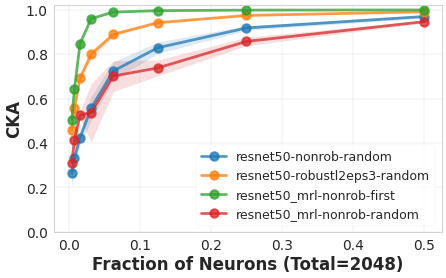

[[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]] [[0.30148537814617155, 0.3570506465435028, 0.4619903016090393, 0.5949197840690613, 0.7420423984527588, 0.8378608107566834, 0.9172457885742188, 0.9679054546356202], [0.38306215167045593, 0.5038324522972107, 0.6357716369628906, 0.7588749241828918, 0.8552257633209228, 0.9245642924308777, 0.9646464085578919, 0.9886283898353576], [0.551950216293335, 0.6372407674789429, 0.8114598989486694, 0.9368049502372742, 0.9833474159240723, 0.9955934286117554, 0.9986931085586548, 0.9996815919876099], [0.3618486249446869, 0.45590611815452575, 0.5382387065887451, 0.5612581217288971, 0.6929762887954712, 0.7346530318260193, 0.8604313349723816, 0.9455149412155152]]


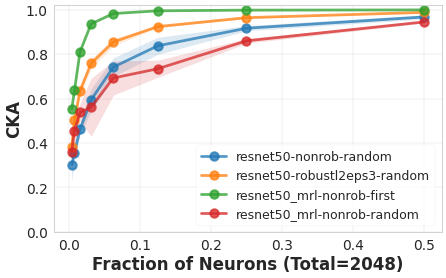

In [33]:
for idx, ft_ds in enumerate(EVAL_DATASETS):
    all_x_vals, all_y_vals, all_full_accs = [], [], []
    legend_vals = []
    for model_name, model_info, model_res in zip(['resnet50', 'resnet50_mrl', 'resnet50_mrl'], 
                                     ['random', 'first', 'random'],
                                     [resnet50_numbers, resnet50_mrl_first, resnet50_mrl_random]):
        for append in CHECKPOINT_PATHS[model_name].keys():
            x, y = list(zip(*sorted(
                model_res[idx][append].items(), key=lambda i:i[0])))
            all_x_vals.append([x_/MODEL_TO_TOTAL[model_name] for x_ in x])
            all_y_vals.append(y)
            legend_vals.append(f'{model_name}-{append}-{model_info}')
    plt_hp.line_plot(
        [[np.mean(_y) for _y in y_vals] for y_vals in all_y_vals], 
        'Fraction of Neurons (Total=2048)', 'CKA', '', 
        subfolder=SOURCE_DATASET, filename=f'part-whole-{MODEL}-{append}-{ft_ds}-random', 
        extension='png', x_vals=all_x_vals, legend_vals=legend_vals, vertical_line=None, 
        colors=plt_hp.COLORS[:len(EVAL_DATASETS)], 
        linestyles=['-']*len(EVAL_DATASETS), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=[True] * len(EVAL_DATASETS), 
        results_subfolder_name='cka_analysis_part_whole', grid_spacing=None, 
        y_err=[[np.std(_y) for _y in y_vals] for y_vals in all_y_vals], legend_ncol=None)

In [ ]:
SOURCE_DATASET = 'imagenet21k'
MODEL = 'vit_small_patch16_224'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())
NUMBERS = [2,5,11,23,47,95,191,382,764]
SEEDS = list(range(1,6))

results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')

In [ ]:
SOURCE_DATASET = 'imagenet21k'
MODEL = 'vit_small_patch32_224'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())
NUMBERS = [2,5,11,23,47,95,191,382,764]
SEEDS = list(range(1,6))

results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')